In [1]:
#JV

I would develop the code for the assignment in this notebook as it is easy to quickly test (and even unit testing).

When a module/part is bug free I would add it to the .py file later.



In [2]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import wandb

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,ChainDataset, ConcatDataset
from torch.utils.data.distributed import DistributedSampler

import matplotlib.pyplot as plt

In [3]:
seed = 76 #setting this as seed wherever randomness comes
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
"""from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/Othercomputers/My Mac/JV SEM2/JV Deep Learning/JV Assignments/JV-Deep-Learning-Assignment2""""

Mounted at /content/drive
/content/drive/Othercomputers/My Mac/JV SEM2/JV Deep Learning/JV Assignments/JV-Deep-Learning-Assignment2


In [5]:
def get_image_sizes(ds):
    """


    """
    x_vals = []
    y_vals = []

    images = []

    for i in range(len(ds.samples)):

        x,y = train_dataset[i][0].shape[1:]

        x_vals.append(x)
        y_vals.append(y)

        #images.append(train_dataset[i][0])

    print(f"X min : {np.min(x_vals)}\tX Max:{np.max(x_vals)}")
    print(f"Y min : {np.min(y_vals)}\tY Max:{np.max(y_vals)}")

#get_image_sizes(train_dataset)
#get_image_sizes(val_dataset)
#get_image_sizes(test_dataset)

Some important points:

1. Images are of different shapes, so they all have to be resized by looking at the image shapes and picking the maximum [or mean/mode ?] width and height.

2. Now they have to be normalized. To zero mean and unit variance. This has to be done within train, test and validation datasets separately. One normalization won't work for the other because the images may go out of scale (i.e beyond +/- 1)


As the maximum dimensions are 800,800 for train, validatio and test data

Resizing all images to 800x800 size.


In [4]:
class CNN(nn.Module):
    """
    A class (that inherits nn.Module), to create the CNN architecture as required and to define the forward pass.
    """

    def compute_output_dimension_post_convolutions(self,convolution_layer_specifications):

            """
            Method to compute the dimension of the output after all convolution,maxpooling layers.
            This helps to compute the input size of first fully connected layer.

            Params:
                convolution_layer_specifications :  A list of lists. There exists one list per conv or maxpool.

                        The first element of the list is a string "conv" or "maxpooling". Indicating the layer type
                "conv" is followed by number of filters, filter sizes, stride, paddings. It is assumed that every convolutional layer is followed by an activation layer.
                "maxpool" is followed by filter size and stride.

            Returns:
                A tuple containing the dimension (Height,Width,depth) of the output after all convolutional operations.
            """

            W_cur = self.W
            H_cur = self.H
            depth_cur = self.input_channels

            for config in convolution_layer_specifications: ## assuming square filters

                layer_type = config[0]

                if layer_type == "conv":  ## its a convolutional layer


                    _, number_of_filters, filter_size, stride, padding = config

                    W_cur = (W_cur - filter_size + 2*padding)//stride + 1
                    H_cur = (H_cur - filter_size + 2*padding)//stride + 1
                    depth_cur = number_of_filters

                elif layer_type == "maxpool":
                    _,max_pool_filter_size,max_pool_stride = config

                    W_cur = (W_cur-max_pool_filter_size)//max_pool_stride + 1
                    H_cur = (H_cur-max_pool_filter_size)//max_pool_stride + 1


            return (H_cur,W_cur,depth_cur)


    def __init__(self,num_output_neurons, conv_activation, fc_activation, convolution_layer_specifications, hidden_layer_specifications, output_activation,conv_batch_norm = False,fc_batch_norm = False, dropout = None,W=800, H=800, input_depth=3):

        """
        Default Constructor.

        Params:

            num_output_neurons: Number of neurons in the output layer.

            conv_activation : A torch nn method to be used as activation function after the convolutional layers.

            fc_activation : A torch nn method to be used as activation function for the fully connected layers.

            convolution_layer_specifications: A list of lists. There exists one list per conv or maxpool.

                        The first element of the list is a string "conv" or "maxpooling". Indicating the layer type
                "conv" is followed by number of filters, filter sizes, stride, paddings. It is assumed that every convolutional layer is followed by an activation layer.
                "maxpool" is followed by filter size and stride.

            hidden_layer_specifications: A list of ints. Number of elements correspond to number of hidden layers and each value gives the number of neurons in the corresponding hidden layer.

            output_activation: The torch nn activation method to be used for the output layer.

            batch_norm  : Applies batch norm after each Convolutional Layer or Fully Connected layer.

            dropout :  The dropout probability (float), default is None.

            H : Height of the input image. [should be fixed for the dataset] (default:800)

            W : Width of the input image.  [should be fixed for the dataset]  (default:800)

            input_depth : Depth of the input image (number of channels). [should be fixed for the dataset] (default:3)


            Note:
                Dropout is a regularization method, and Convolutional layers by construction have sparse and shared weights so they have regularization inbuilt,

                hence dropout is applied only to the fully connected layers.


        Returns:

            None.
        """

        super(CNN, self).__init__()

        self.H = H
        self.W = W
        self.input_channels = input_depth
        self.output_activation = output_activation
        self.convolution_layer_specifications = convolution_layer_specifications

        self.convolutional_layers = nn.ModuleList() ## Create a module list to organize the convolutional layers

        self.dropout  = dropout

        ## iterate over the convolution_layer_specifications and create the convolutional layers accordingly

        cur_depth = self.input_channels
        for config in convolution_layer_specifications:

            ## Assuming filter is a square matrix, so filter_size is int.
            type = config[0]

            if type == "conv":
                _, number_of_filters, filter_size, stride, padding = config
                self.convolutional_layers.append(nn.Conv2d(cur_depth, number_of_filters, filter_size, stride, padding))
                ## If batchnorm is to be done for Conv layers
                if conv_batch_norm:
                    self.convolutional_layers.append(nn.BatchNorm2d(number_of_filters))
                self.convolutional_layers.append(conv_activation)  # Add activation after each convolutional layer

            elif type == "maxpool":
                _,max_pool_filter_size,max_pool_stride = config
                self.convolutional_layers.append(nn.MaxPool2d(max_pool_filter_size,max_pool_stride))

            cur_depth = number_of_filters  # Update input depth for next layer

        #self.convolutional_layers.apply(self.initalize_weights_biases)

        ## iterate over the hidden_layer_specifications and create CNN layers accordingly.
        self.hidden_layers = nn.ModuleList()

        conv_output_height,conv_output_height,conv_output_depth = self.compute_output_dimension_post_convolutions(convolution_layer_specifications)

        #if self.dropout:

        #    self.dropout_layer = nn.Dropout(p=self.dropout) ## a drop out layer with dropout


        fan_in =  conv_output_height*conv_output_height*conv_output_depth ## interface betweeon maxpooling and dense layer

        for hidden_size in hidden_layer_specifications:
            self.hidden_layers.append(nn.Linear(fan_in, hidden_size))

            ## If batchnorm is to be done for FC layers
            if fc_batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_size))

            self.hidden_layers.append(fc_activation)  # Add ReLU activation after each dense layer

            if self.dropout:
                self.hidden_layers.append(nn.Dropout(p=self.dropout))

            fan_in = hidden_size  # Update number of input features for next layer

        #self.hidden_layers.apply(self.initalize_weights_biases)

        self.output = nn.ModuleList()
        self.output.append(nn.Linear(hidden_layer_specifications[-1], num_output_neurons))
        self.output.append(self.output_activation)

        #self.output.apply(self.initalize_weights_biases)



    def forward(self,x):

        ## pass through convolution, activation, pooling layer set
        for layer in self.convolutional_layers:
            x = layer(x)

        x = torch.flatten(x, 1)


        ## pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)

        for layer in self.output: ## compute output and apply softmax
            x = layer(x)

        return x


    def initalize_weights_biases(self,m):
        """

        Method to initialize weights given a torch module.

        Using "HE" (kaiming_normal) Initialization, as it goes well with ReLU in CNN.

        """
        if isinstance(m, nn.Linear):  ## it its a fully connected layer
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01) ##a small non-zero value

        elif isinstance(m, nn.Conv2d): ## if its a Convolutional layer
            torch.nn.init.kaiming_uniform_(m.weight)
            m.bias.data.fill_(0.01) ##a small non-zero value

        ## Maxpool and activation layers would not have any parameters, so no initialization for them

    def convolution_dimensions(self,input_channels):

        """
        Method to print the dimensions of the outputs of all the convolutional pooling layers
        """

        W_cur = self.W
        H_cur = self.H
        depth_cur = input_channels
        total_params = 0

        for config in self.convolution_layer_specifications: ## assuming square filters

            #print(number_of_filters, filter_size, stride, padding, max_pool)
            layer_type = config[0]

            if layer_type == "conv":  ## its a convolutional layer


                _, number_of_filters, filter_size, stride, padding = config

                W_cur = (W_cur - filter_size + 2*padding)//stride + 1
                H_cur = (H_cur - filter_size + 2*padding)//stride + 1

                params = filter_size*filter_size*depth_cur*number_of_filters
                total_params += params

                print(f"Number of Parameters : {params}\n")
                depth_cur = number_of_filters

                print(f"Shape after conv : {W_cur}x{H_cur}x{depth_cur}")

            elif layer_type == "maxpool":
                _,max_pool_filter_size,max_pool_stride = config

                W_cur = (W_cur-max_pool_filter_size)//max_pool_stride + 1
                H_cur = (H_cur-max_pool_filter_size)//max_pool_stride + 1
                print(f"Shape after MP : {W_cur}x{H_cur}x{depth_cur}")


        print(f"\nFinal Shape : {W_cur}x{H_cur}x{depth_cur}")

        print(f"Total Convolutional params : {total_params}")


In [5]:
class DataPreparation:

    def __init__(self,H,W,data_dir,device,perform_standardization=False):

        self.H = H
        self.W = W
        self.base_dir  = data_dir
        self.device = device
        self.perform_standardization = perform_standardization

    def compute_mean_and_dev_in_dataset(self,sub_dir):

        """
        Method to compute the channel wise mean and std dev in the orignal (train/validation/test) dataset.

        params:

            sub_dir : "train/" or "validation/" or "test/", from which data has to be taken.

        Returns:

            mean,std of the dataset.

        """

        data_transforms = transforms.Compose(
        [
            transforms.Resize(size=(self.H,self.W)),
            transforms.ToTensor(),
        ]
        )

        dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=data_transforms)
        loader = torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=False,num_workers=3)

        mean = 0.0
        var = 0.0
        count = 0

        for _, data in enumerate(loader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(self.device), labels.to(self.device) ## move the inputs and lables to the device.

            # Reshape inputs to be the shape of [B, C, W * H]
            # where B is the batch size, C is the number of channels in the image, and W and H are the width and height of the image respectively
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)

            # Update total number of images
            count += inputs.size(0)

            # Compute mean and std here
            mean += inputs.mean(2).sum(0)
            var += inputs.var(2).sum(0)

        mean /= count
        var /= count
        std = torch.sqrt(var)

        #print(mean.cpu(),std.cpu())

        return mean.cpu(),std.cpu()

    def create_dataloader(self,sub_dir,batch_size=32,shuffle=True,num_workers=2,data_augmentation_transforms = None,pin_memory = False):

        """
        Method to create dataset and return dataloader after applying all necessary transforms.

        params:

            sub_dir : "train/" or "validation/" or "test/"
            batch_size : The batch size in which training has to be performed.
            shuffle : whether shuffling must be done before sampling.
            num_works : Number of workers to be used on the dataset.
            data_augmentation_transforms : Either None or List of List of transforms, with each sub-list leading to a dataset.

        Returns:

            Dataloader corresponding to the dataset.

        """

        print(f"Preparing data from {sub_dir}")

        default_transform = [transforms.Resize(size=(self.H,self.W))]  ## to be applied always

        standardization_transform = []
        ## if data standardization needs to be done.
        if self.perform_standardization:
            mean,std = self.compute_mean_and_dev_in_dataset(sub_dir)
            standardization_transform = [transforms.Normalize(mean,std)]

        ## The most basic list of transforms applied to the orignal train dataset and validation and test dataset.
        vanilla_transforms = default_transform + [transforms.ToTensor()] + standardization_transform

        if ("train" in sub_dir) and (data_augmentation_transforms): ## if data augmentation is to be done

            original_dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=transforms.Compose(vanilla_transforms))

            dataset_list = [original_dataset]

            for aug_transform in data_augmentation_transforms:

                cur_data_transforms_list = default_transform + aug_transform + [transforms.ToTensor()] + standardization_transform
                cur_dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=transforms.Compose(cur_data_transforms_list))
                dataset_list.append(cur_dataset)

            self.dataset = ConcatDataset(dataset_list)

        else:

            self.dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=transforms.Compose(vanilla_transforms))



        ## Now create the data loader

        sampler = None ## unless the dataloading is distributed across devices or processes.

        if "train" in sub_dir:

            #torch.distributed.init_process_group(rank=0,world_size = 4)

            #sampler = DistributedSampler(self.dataset)

            self.loader = torch.utils.data.DataLoader(dataset=self.dataset,batch_size=batch_size,shuffle=shuffle,num_workers=num_workers,pin_memory = pin_memory,sampler=sampler)

        else:

            #num_workers = 3
            #pin_memory = False

            self.loader = torch.utils.data.DataLoader(self.dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory = pin_memory,sampler=sampler)

        return self.loader


In [240]:
class Experiment:

    """
    Class to create and conduct experiments
    """

    def __init__(self,H,W,device,base_dir,wandb_logging=False):

        self.H = H
        self.W = W
        self.device = device
        self.base_data_dir = base_dir
        self.wandb_logging = wandb_logging

    def create_dataloaders(self,batch_size,shuffle,perform_standardization,list_of_train_data_augmentation_transforms,num_workers=0,pin_memory=False):

        """
        Method to create dataloaders for train,test and validation datasets, with the help from the DataPreparation class.

        params:

            batch_size : The training batch size (also applied to test and validation loaders, but anyway its still the same).
            shuffle : True/False, whether to shuffle data before sampling.
            perform_standardization : True/False, says if data has to be brought to zero mean and unit variance.
            list_of_train_data_augmentation_transforms : None, if no data augmentation or List of List of transforms, with each sub-list leading to a dataset.
            num_workers : Number of workers to support the dataloader, default is 0.
            pin_memory : Default is False. Pinning memory makes data loading efficent when a accelerator is used and num of workers>0.

        Returns:

            Torch dataloader objects for training,testing and validation data.



        """
        ## Create an object of the data preparation class
        dataprep = DataPreparation(H=self.H,W=self.W,data_dir=self.base_data_dir,device = self.device, perform_standardization = perform_standardization)

        if (not self.device == "cpu") and num_workers>0:
            pin_memory = True

        ## create a train dataset loader
        self.train_loader = dataprep.create_dataloader(sub_dir = "train/",batch_size = batch_size,shuffle = shuffle, num_workers = num_workers,data_augmentation_transforms = list_of_train_data_augmentation_transforms,pin_memory=pin_memory)

        ## it is not efficient to pin memory for validation and test datasets,as they are relatively small.
        self.val_loader = dataprep.create_dataloader(sub_dir = "validation/",batch_size = batch_size,shuffle = shuffle, num_workers = num_workers,pin_memory=False)
        self.test_loader = dataprep.create_dataloader(sub_dir = "test/",batch_size = batch_size,shuffle = shuffle, num_workers = num_workers,pin_memory=False)

        return self.train_loader,self.val_loader,self.test_loader


    def createCNNmodel(self,num_output_neurons, conv_activation,fc_activation ,convolution_layer_specifications, hidden_layer_specifications, output_activation, conv_batch_norm, fc_batch_norm, dropout ,W, H, input_depth):

        """
        Method to create CNN model with the given configuration for the experiment.

        Params:

            num_output_neurons: Number of neurons in the output layer.

            conv_activation : A torch nn method to be used as activation function after the convolutional layers.

            fc_activation : A torch nn method to be used as activation function for the fully connected layers.

            convolution_layer_specifications: A list of lists. There exists one list per conv or maxpool.

                        The first element of the list is a string "conv" or "maxpooling". Indicating the layer type
                "conv" is followed by number of filters, filter sizes, stride, paddings. It is assumed that every convolutional layer is followed by an activation layer.
                "maxpool" is followed by filter size and stride.

            hidden_layer_specifications: A list of ints. Number of elements correspond to number of hidden layers and each value gives the number of neurons in the corresponding hidden layer.

            output_activation: The torch nn activation method to be used for the output layer.

            batch_norm  : Applies batch norm after each Convolutional Layer or Fully Connected layer.

            dropout :  The dropout probability (float) or None.

            H : Height of the input image. [should be fixed for the dataset]

            W : Width of the input image.  [should be fixed for the dataset]

            input_depth : Depth of the input image (number of channels). [should be fixed for the dataset]


            Note:
                Dropout is a regularization method, and Convolutional layers by construction have sparse and shared weights so they have regularization inbuilt,

                hence dropout is applied only to the fully connected layers.


        Returns:

            None.

        """

        self.model = CNN(num_output_neurons=num_output_neurons, conv_activation=conv_activation,fc_activation = fc_activation ,convolution_layer_specifications=convolution_layer_specifications, hidden_layer_specifications=hidden_layer_specifications, output_activation = output_activation, conv_batch_norm = conv_batch_norm, fc_batch_norm = fc_batch_norm, dropout = dropout ,W=W, H=H, input_depth=input_depth)
        self.model.apply(self.model.initalize_weights_biases)
        self.model.to(self.device)

    def compute_accuracy(self,model,data_iterator):

        """
        Method to compute the accuracy of the given model over the dataset in the data_iterator.

        params:

            model : The torch neural net model whose performance has to be measured.

            data_iterator : The data iterator over which the computation of the metrics has to be done.

        Returns:

            loss,accuracy of the "model" over the "data_iterator".
        """

        correct_preds = 0
        total_preds = 0

        loss = 0
        train_mode = model.training

        # since we're testing, switch of train mode if it is on.
        if train_mode:
            model.eval()

        with torch.no_grad(): ##don't compute gradients
            for _,data in enumerate(data_iterator):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device) ## move the inputs and labels to the device

                # calculate outputs by running images through the network
                outputs = model(images)
                loss += self.criterion(outputs, labels).item() * images.size(0) ## loss.item() is average loss of the batch, so multiply by batch size.

                preds = torch.max(outputs.data, 1)[1]

                total_preds += images.size(0)
                correct_preds += (preds == labels).sum().item()

        if train_mode: # if model was originally in train mode, switch it back to train mode.
            model.train() ## switch back to train mode

        #print(f'Accuracy of the model on the {len(data_iterator.dataset.samples)} test images: {round(100*correct/total,2)} %')

        accuracy = round(100*correct_preds/total_preds,2)
        loss = round(loss/total_preds,2)

        return loss,accuracy

    def train(self,lr,weight_decay,loss,optimiser,epochs):

        """
        The method to perform the training, assuming model is already created using createCNNmodel method.

        Params:

            lr : Learning rate
            weight_decay : l2 regularization parameter.
            loss : string, loss type. currently only "crossentropy" is supported
            optimiser : "adam","nadam","rmsprop".
            epochs : number of epochs to train.

        Returns:

            None.
        """

        ## specify the optimiser
        if optimiser.lower() == "adam":
            self.optimiser = optim.Adam(self.model.parameters(), lr=lr,weight_decay=weight_decay)

        elif optimiser.lower() == "nadam":
            self.optimiser = optim.NAdam(self.model.parameters(), lr=lr,weight_decay=weight_decay)

        elif optimiser.lower() == "rmsprop":
            self.optimiser = optim.RMSprop(self.model.parameters(), lr=lr,weight_decay=weight_decay)

        ## Specify the loss criteria
        if loss.lower() == "crossentropy":
            self.criterion = nn.CrossEntropyLoss().to(self.device)


        start_time = time.time()

        ## loop over the dataset multiple times
        for epoch in tqdm(range(epochs)):

            correct_preds = 0
            total = 0
            count = 0
            epoch_loss = 0.0


            for i, data in enumerate(self.train_loader):

                ## i is batch index

                #print(i)

                images, labels = data[0].to(self.device),data[1].to(self.device)  ## move the images and labels to the device.


                # zero the parameter gradients
                self.optimiser.zero_grad()

                # forward + backward + optimize
                outputs = self.model(images).to(self.device)

                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimiser.step()

                epoch_loss +=  loss.item() * images.size(0) ## loss.item() is average loss of the batch, so multiply by batch size.

                preds = torch.max(outputs.data, 1)[1]

                total += images.size(0)
                correct_preds += (preds == labels).sum().item()


            train_accuracy = round(100*correct_preds/total,2)
            train_loss = epoch_loss/total

            val_loss,val_accuracy = self.compute_accuracy(self.model,self.val_loader)

            
            """if val_accuracy>39:

                file_name = "ValAcc-"+str(val_accuracy)
                torch.save(self.model, "Model-"+file_name)"""

            if epoch == 0:
                print(f"Samples in Train Data : {total}")

            if self.wandb_logging:

                wandb.log({'train loss': train_loss, 'train accuracy': train_accuracy, 'Validation loss': val_loss, 'Validation accuracy': val_accuracy,'epoch': epoch+1})

            print(f'Epoch : {epoch+1}\t Train Accuracy : {train_accuracy:.2f}%\t Train loss: {train_loss:.2f}\t Validation Accuracy : {val_accuracy:.2f}%\t Validation Loss : {val_loss:.2f}')
            epoch_loss = 0.0

        print('Finished Training!!')

        end_time = time.time() - start_time
        print(f"Time Taken for Training: {round(end_time/60,2)}")


    def plot_images_with_predictions(self,images,true_class, pred_classes,preds_correct_or_not,class_names, num_rows=10, num_cols=3):

        pred_accuracy = round(np.mean(preds_correct_or_not)*100,2)
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))
    
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                axes[i, j].imshow(images[idx].permute(1, 2, 0))
                
    
                # Add a colorful border around the image based on prediction
                color = 'green' if preds_correct_or_not[idx] == 1 else 'red'
                axes[i, j].spines['left'].set_color(color)
                axes[i, j].spines['top'].set_color(color)
                axes[i, j].spines['right'].set_color(color)
                axes[i, j].spines['bottom'].set_color(color)
    
                axes[i, j].set_title(f"{class_names[true_class[idx]]} predicted as {class_names[pred_classes[idx]]}", color=color, fontsize=10)
    
        plt.suptitle(f'Sample of Thirty Test Images with Predictions \n(Accuracy {pred_accuracy}%)', fontsize=20, color='blue')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust title position
        
        if self.wandb_logging:
            wandb.log({"Test Image Predictions": [wandb.Image(plt, caption="")]})
        
        plt.show()


    def test_model(self,plot_sample_images = False,model_path=None):

        """
        Method to run find the performance of the self.model on test data. A stored model could also be loaded.

        params:
            plot_sample_images : Randomly samples 30 test images, predicts and plots them.
            model_path : Default is None, else it the the path to the model to be loaded
        """

        if model_path:
            model = torch.load(model_path,map_location=torch.device(self.device))
        else:
            model = self.model

        self.criterion = nn.CrossEntropyLoss().to(self.device)

        val_loss,val_accuracy = self.compute_accuracy(model,self.val_loader)
        test_loss,test_accuracy = self.compute_accuracy(model,self.test_loader)
        
        print(f'Validation Accuracy : {val_accuracy:.2f}%\t Validation loss: {val_loss:.2f}')
        print(f'Test Accuracy : {test_accuracy:.2f}%\t Test loss: {test_loss:.2f}')

        if plot_sample_images: ## have to create a new dataloader that randomly samples from test data

            vanilla_transforms = [transforms.Resize(size=(600,600)),transforms.ToTensor()]
            test_dataset = torchvision.datasets.ImageFolder(root= self.base_data_dir+'test/',transform=transforms.Compose(vanilla_transforms))
            test_sampler = torch.utils.data.RandomSampler(test_dataset)
            test_loader = DataLoader(test_dataset, batch_size=30, sampler=test_sampler) ## batch size 30 so that we can sample 30 images at once.
            
            data = next(iter(test_loader))
            data = next(iter(test_loader))
            data = next(iter(test_loader))
            data = next(iter(test_loader))
            data = next(iter(test_loader))
            data = next(iter(test_loader))
            data = next(iter(test_loader))
            test_images,test_labels = data[0].to(self.device),data[1].to(self.device)


            class_names = self.test_loader.classes

            
            pred_class = torch.max(model(test_images),1)[1].cpu().detach().numpy()
            
            test_labels = test_labels.cpu().detach().numpy()
            
            preds = [0]*30
            
            preds = [1 if pred_class[i]==test_labels[i] else 0 for i in range(len(pred_class))]

            self.plot_images_with_predictions(test_images.to('cpu'),test_labels,pred_class,preds,class_names)





In [196]:
wandb.login(key="")


sweep_config = {
    'method': 'random',
    'name' : 'PA2 Hyper Sweep Factor Two',
    'metric': {
      'name': 'Validation accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'num_hidden_layers': {
            'values': [1]
        },
         'hidden_size':{
            'values':[32,64,128,256]
        },
        'activation': {
            'values': ['relu','silu','tanh']
        },

        'optimiser': {
            'values': ["adam","rmsprop","nadam"]
        },

        'num_conv_layers' :{
            'values' : [5]
        },

        'conv_filter_factor':{
            'values' : [2]
        },

        'num_filters':{
            'values' : [4,8,16]
        },

        'filter_size':{
            'values' : [5,7,11]
        },


        'lr': {
            'values': [1e-3,1e-4,3e-4]
        },
        'weight_decay': {
            'values': [0,5e-3,5e-4]
        },

        'batch_norm' : {
            'values' : [True, False]
        },

        'dropout' : {

            'values' : [None,0.2,0.3]
        },

        'data_aug' : {

            'values' : [None,1,2]
        },

        'epochs' : {

            'values' : [8]
        },

        'Image_Crop_Size':{
            'values' : [500,600,800]
        },

        'batch_size' : {

            'values' : [16,32]
        }

        }
    }

sweep_id = wandb.sweep(sweep=sweep_config, project='JV_CS23M036_TEJASVI_DL_ASSIGNMENT2')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/tejasmalladi/.netrc


In [242]:
def setup_and_start_expt(config,wandb_log=False,data_dir = "inaturalist_12K/",model_path = None):
    
    
    wandb_logging = wandb_log
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    base_data_dir = data_dir
    

    print(f"Using {device}")

    H = W = config['Image_Crop_Size']

    ## dataloader creation hyperparams:

    batch_size = config['batch_size']
    shuffle = True
    num_workers = 8
    perform_standardization = False
    pin_memory = True

    #RandomSolarize(threshold=192.0)

    if config['data_aug']:

        train_data_augmentation_transforms1 = [transforms.RandomPerspective(p=1)] ## Random perspective transform
        train_data_augmentation_transforms2 = [transforms.ColorJitter(brightness=.5, hue=.5)] ## colour jitter
        #train_data_augmentation_transforms = [transforms.ElasticTransform()] ## this is good, but computationally extremely expensive

        list_of_train_data_augmentation_transforms = [train_data_augmentation_transforms1,train_data_augmentation_transforms2]
        list_of_train_data_augmentation_transforms = list_of_train_data_augmentation_transforms[:config['data_aug']]

    else: ## if no data augmentation, train_loader returned would just be on the original dataset.

        list_of_train_data_augmentation_transforms = []


    ## create an experiment
    experiment = Experiment(H=H,W=H,device=device,base_dir = base_data_dir, wandb_logging=wandb_logging)


    ##create data loaders for train, validation and test datasets.
    train_loader,val_loader,test_loader  = experiment.create_dataloaders(batch_size=batch_size,shuffle=shuffle,perform_standardization=perform_standardization,list_of_train_data_augmentation_transforms=list_of_train_data_augmentation_transforms,num_workers=num_workers,pin_memory=pin_memory)
    
    if model_path: ## no need to actually do the training

        experiment.test_model(plot_sample_images = False,model_path=model_path)
        return None
    
    ## CNN Hyperparams
    num_output_neurons =  len(val_loader.dataset.classes)

    num_conv_layers = config["num_conv_layers"]
    conv_filter_size = config['filter_size']
    num_filters = config['num_filters']
    factor = config['conv_filter_factor']
    maxpool_filter_size = 2

    ## create the convlution layer specifications
    convolution_layer_specifications = []
    for i in range(num_conv_layers):

        if i == 0:
            conv_stride = 1
            pool_stride = 1
            padding = (conv_filter_size-1)
        else:
            conv_stride = 2
            pool_stride = 1
            padding = 0

        conv_layer = ["conv",num_filters,conv_filter_size,conv_stride,padding]
        maxpool_layer = ["maxpool",maxpool_filter_size,pool_stride]

        convolution_layer_specifications.append(conv_layer)
        convolution_layer_specifications.append(maxpool_layer)
        num_filters *= factor


    hidden_layer_specifications = [config['hidden_size']] * config["num_hidden_layers"]

    if config['activation'].lower() == "relu":
        fc_activation = nn.ReLU()

    elif config['activation'].lower() == "silu":
        fc_activation = nn.SiLU()

    if config['activation'].lower() == "tanh":
        fc_activation = nn.Tanh()


    ## fixing this as per the litearture.
    conv_activation=nn.ReLU()

    output_activation = nn.LogSoftmax(dim=1)

    if config['batch_norm']:
        conv_batch_norm = True
        fc_batch_norm = True
    else:
        conv_batch_norm = False
        fc_batch_norm = False

    dropout = config['dropout']

    input_depth=3

    ## create CNN model
    experiment.createCNNmodel(num_output_neurons, conv_activation,fc_activation ,convolution_layer_specifications, hidden_layer_specifications, output_activation, conv_batch_norm, fc_batch_norm, dropout ,W, H, input_depth)

    ## To see outputs of convolution and maxpool layers
    #experiment.model.convolution_dimensions(input_channels = input_depth)

    ##training Hyper Params:

    lr = config['lr']
    weight_decay = config['weight_decay']
    optimiser = config['optimiser']
    epochs = config['epochs']
    loss = "crossentropy"
    
    experiment.train(lr = lr,weight_decay = weight_decay,loss = loss,optimiser = optimiser,epochs = epochs)

    return experiment.model


### Notes on Hyperparameter Tuning

Some Simplifying assumptions:

1. A maxpool layer always follows a conv layer and there are 5 convolutional layers
2. First conv layer has a padding of f-1 and remaning have padding of 0
3. Stride of first convolutional and maxpool layers are 1 and rest all are 2.
4. Maxpool stride is always 1.
5. Assuming Activation of conv layers is always relu, based on literature and hence reducing the search space. The activation is applied for the hidden layers.
6. BatchNorm when true, would be done for both the convolutional and fully connected layers.
7. Cnovolutional layers have sparse weights with weight sharing hence by construction have inbuilt regularization, so dropout is applied only to the fully connected layers.
8. Intutively L2 regularization would also control the convolutional layer's weights, which are by definition regularized, hence it may not be good. We'll Test this out.
9. Going by the literature, Maxpool is done after activation, Batchnorm is done before activation and dropout is done after activation.
10. We have seen in the class that controlled and systematic initialization is important for model to learn and converge. As we are fixing ReLU regularization for convolutional layers, we would use HE initialization for convolutional layers and Xavier for the fully connected layers, which in general goes well with all the activations.
11. With the number of filters factor, we are carefully setting possible the number of filters, by running separate experiments for factors  = 0.5,1,2
12. Data Augmentation : None, meaning no data augmentation. 1 means only random perspective is applied as augmentation and 2 means both random perspective and colour jitter are applied, separately.
13. Using LogSoftmax over softmax activation as it propogates gradients better, nullifying the effect of exponents, and since log is a monotonously increasing function, larger probabilities would mean larger values after log. Hence we can still use argmax to classify.

We are reducing search space by learning from literature : fixing maxpool stride and filter size, actiation of convolutional layers, and accordingly using HE initialization for conv. layer and xavier for Fully connected layers.


In [222]:
best_hyperparm_config = {
        'num_hidden_layers' : 1,

        'hidden_size' : 64,

        'activation' : 'relu',

        'optimiser' : "rmsprop",

        'num_conv_layers' : 5,

        'conv_filter_factor': 1,

        'num_filters' : 32,

        'filter_size' : 5,

        'lr' : 3e-4,

        'weight_decay' : 5e-4,

        'batch_norm' : True,

        'dropout' : 0.2,

        'data_aug' : 1,

        'epochs' : 8,

        'Image_Crop_Size':600,

        'batch_size' : 16
    }


In [243]:
setup_and_start_expt(best_hyperparm_config,model_path = "BestModelPartA")

Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/
Validation Accuracy : 40.20%	 Validation loss: 1.73
Test Accuracy : 42.45%	 Test loss: 1.68


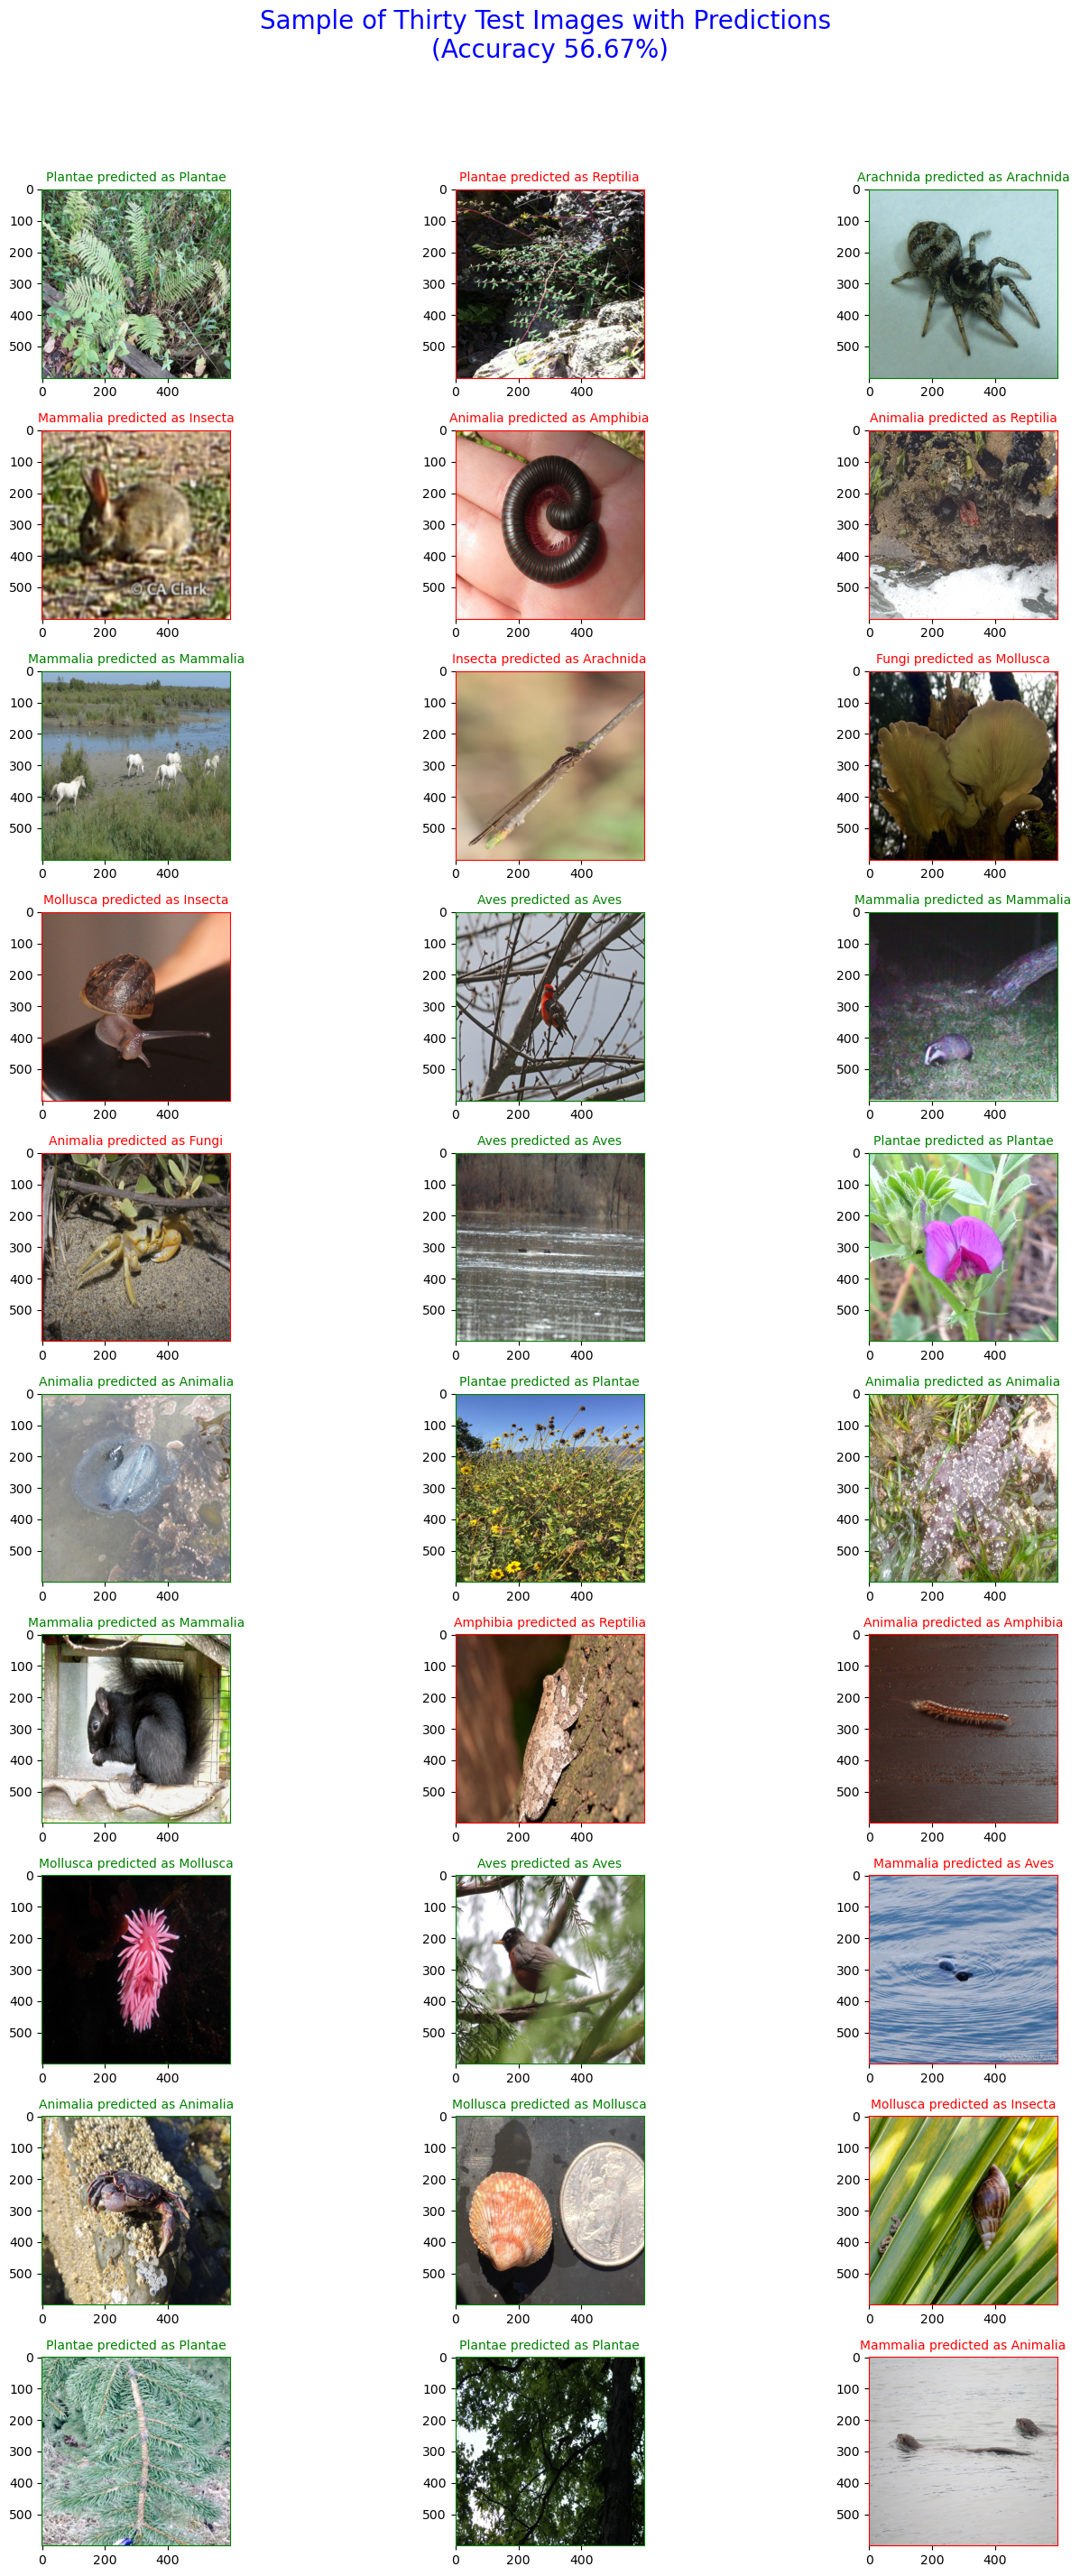

In [202]:
plot_images_with_predictions(test_images.to('cpu'),test_labels,pred_class,preds,class_names)

In [ ]:
"""
base_data_dir from arg parser, default is "inaturalist_12K/"
"""

In [ ]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''


    with wandb.init() as run:

        run_name="-hl_"+str(wandb.config.num_hidden_layers)+"-hs_"+str(wandb.config.hidden_size)+"-ac_"+str(wandb.config.activation)

        run_name = run_name+"-optim_"+str(wandb.config.optimiser)+"-lr_"+str(wandb.config.lr)+"-reg_"+str(wandb.config.weight_decay)+"-epochs_"+str(wandb.config.epochs)+"-data_aug"+str(wandb.config.data_aug)

        run_name = run_name+"-dropout_"+str(wandb.config.dropout)+"-batch_norm_"+str(wandb.config.batch_norm)+"-conv_filter_factor_"+str(wandb.config.conv_filter_factor)+"-num_filters_"+str(wandb.config.num_filters)+"-filter_size_"+str(wandb.config.filter_size)

        wandb.run.name=run_name

        setup_and_start_expt(wandb.config,wandb_log = True,base_data_dir)


wandb.agent(sweep_id, function=main,count=100) # calls main function for count number of times.
wandb.finish()

### References:

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=PyTorch%20provides%20two%20data%20primitives,easy%20access%20to%20the%20samples.
3. https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel [to create dataloaders]
4. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html [To understand overall structure of torch code]
5. https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html [for composing transform]
6. https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html [for resizing images]
7. https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize [For normalization]
8. https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py [For data augmentation]
9. https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch [Plotting a tensor as an image]
10. https://stackoverflow.com/questions/52095337/plotting-grids-across-the-subplots-python-matplotlib [Plotting Test data]